In [14]:
import numpy as np
from matplotlib import pyplot as plt

We're going to use the 1 layer model shown below.

![1 Layer](1layer.png)

In [15]:
A = np.load('A.npy')#.astype(np.uint8)
B = np.load('B.npy')#.astype(np.uint32)
test_image = np.load('test_image_label_27.npy')
print(A.shape, B.shape)
print(test_image.shape, test_image.dtype)

(10, 784) (10,)
(28, 28) float32


In [16]:
print(0.011801077052950859 * A.flatten()[0:5])
print(0.000046278735680971295 *B[0:5])

[-0.05900539  0.05900539 -0.04720431  0.07080646  0.01180108]
[-0.11995448 -0.02008497  0.16826948 -0.1149101   0.24893332]


For index 27, the expected label is 4. Here's the expected tensor output, obtained by running the TFLite Interpretor on the same test image:

**[  0   0   0   0 130  25  23  17  38  77]**

The same result from running TFLite Interpretor on the float32 model:

**[ 0.         0.         0.         0.        10.18009    1.9682264
  1.7667338  1.2612104  2.9864843  6.0077305]**

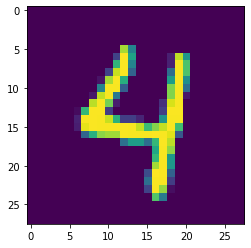

In [17]:
plt.imshow(test_image)
plt.show()

In [18]:
#print(test_image)
#print(test_image_uint8)

In [19]:
def ReLU(x):
    return x * (x > 0)

Now test the inference by converting weights to float using the quantization parameters in the file.

In [20]:
X = test_image.flatten()

qa1 = 0.011801077052950859
qb1 = 0.000046278735680971295 
X1 = np.matmul(A*qa1, X) + B*qb1
X1 = ReLU(X1)
# X1 = 0.07775364816188812 * (X1 + 128)
#  0.07775364816188812 * q

print(X1, X1.shape)
print("argmax: {}".format(np.argmax(X1)))

X1_uint8 = np.array(X1 / 0.07775364816188812, dtype=np.uint8)
print(X1_uint8)

[-0.         -0.         -0.         -0.         10.10968199  1.97744403
  1.76044303  1.31551931  2.9919664   5.98615422] (10,)
argmax: 4
[  0   0   0   0 130  25  22  16  38  76]


This matches with the FTlite interpretor output on the same data.

Now let's run this using integer math.

In [29]:
S1 = 0.011801077052950859
S2 = 0.003921568859368563
Z2 = -128
Z3 = 0
S4 = 0.07775364816188812 
Z4 = -128
print(0.003921568859368563 * 0.011801077052950859)

X = test_image.flatten()
X1 = ReLU(np.matmul(S1*A, X) + B*(S1*S2))
print(X1)

Xq = np.array(X/S2, dtype=np.uint8)
#print(Xq)
X1 = np.array(np.matmul(A.astype(np.int32), Xq) + B, dtype=np.int32)
print(X1)
print(S1*S2*X1)

SR = np.sum(A, axis=1)
#print(SR)

q4 = ReLU((S1*S2/S4)*X1)
print(q4.astype(np.uint8))

4.627873627786102e-05
[-0.         -0.         -0.         -0.         10.10968199  1.97744404
  1.76044303  1.31551931  2.99196639  5.98615422]
[-18651 -33021 -12080 -20606 217723  42527  37920  28341  64282 128821]
[-0.86314471 -1.52817015 -0.55904713 -0.95361964 10.0759453   1.96809582
  1.75488968  1.31158566  2.97488973  5.96167309]
[  0   0   0   0 129  25  22  16  38  76]


Test summation

In [23]:
x = np.array([[1, 2, 3], [4, 5, 6]])
print(x, x.shape)
y = np.sum(x, axis=1)
print(y, y.shape)

[[1 2 3]
 [4 5 6]] (2, 3)
[ 6 15] (2,)


In [24]:
print(A[0])
print(np.sum(A[0]))

[ -5   5  -4   6   1   3   1  -4  -5   7  -3   1   2  -1  -5   3   3  -3
   7   0   6  -6   3   0   5  -2   2   4  -6   5  -7  -7  -7   4  -5  -1
  -1  -6 -17   6  15   4 -32 -14 -33 -21 -27  -3   0  -1   1  -1  -7  -3
   4   2  -6  -4   0   5   3 -16 -22 -18 -23 -32 -39 -16 -22 -26 -44 -75
 -50 -67 -69 -48 -40 -44 -22 -14  -5  -3   4   1  -5   7  -5   9  -6 -21
 -26 -14  -2 -19  -8  -2  -4  -3  -2  -5   3  -5 -24 -24 -20 -33 -35 -12
  -9  -4 -14  -2   1   3  -7  -3 -15 -21 -21  -8  -4  10   3   5 -11   1
  -7  -1  -2   1  -3 -14 -12 -10  -2 -13 -25 -19 -10  -4   4  -3 -19   0
 -24 -32  -8  -5   1  -6   7   7  -8   5  16   7   3  16  16   5  -3  -3
   1 -22 -26 -62 -47 -10  -6   3 -13 -16 -32  -9  -9   7  -1 -18   7   5
   4  10  13  11  10  22  16   8   5  19  11 -10 -38 -81 -54  -7  -7 -15
 -11 -21 -33  -9   5  -9 -17   1   8  12   6  14   5  14  14  20  21   9
   7   7  10  19  -9 -55 -39 -18  12  -9   2   3 -32  -4  -1  -2   0   8
  12  12  10   5   7  18  31  21  28  20  11  11  1